# 通し課題：クラウドファンディングが始まる前に成功するかを予測する DAY3
* DAY1,DAY2の内容を生かし、精度向上を目指す

#### Day1特定した説明変数を使って精度を上げる
* DAY1で特定した目的変数:state
* DAY1で特定した説明変数

|説明変数|説明|備考|
|:-|:-|:-|
|usd_goal_real|目標額USDドル換算||
|days|プロジェクト期間 (deadline-launched)||
|country|国|ダミー変数|
|category|カテゴリ|ダミー変数|


#### DAY2からの反省を取り込む
* ロジステック回帰とSVMの精度比較時のデータセットが違った→データセットを統一して精度を比較する
* SVMのgammaをautoで実施していた→グリッドサーチのパラメータを見直す

In [1]:
#ライブラリ読み込み
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

## 0.データセットの準備
* 各モデルの評価を比較するため、共通の学習用、テスト用データを準備する
* 元データセット:ks-projects-201801.csv
* 元データセットからDAY1で特定した説明変数、目的変数で計算できるよう編集する
* 学習用8割：X_train,y_train、最終テスト用2割：X_test,y_testに分割

In [2]:
# データの読み込み
df = pd.read_csv('ks-projects-201801.csv')
df = df[df['state'].isin(['failed','successful'])]
df["state"] = df["state"]=="successful"
display(df.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,False,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,False,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,False,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,True,224,US,52375.0,52375.0,50000.00


In [3]:
# 欠損値確認
df.isnull().sum()

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

* nameは説明変数に使用しないので欠損値処理なし
* usd pledgedは説明変数に使用しないので欠損値処理なし

In [4]:
df_cloud = df.copy()
# 期間(deadline - launched) days
# 期間の長さを求める
df_cloud['launched'] = pd.to_datetime(df_cloud['launched'])
df_cloud['deadline'] = pd.to_datetime(df_cloud['deadline'])
df_cloud['period'] = df_cloud['deadline'] - df_cloud['launched']
# daysだけ抽出
days = [] 
for i in df_cloud.index:
    days.append(df_cloud['period'][i].days)
#'days'の列を追加 
df_cloud['days'] = days
df_cloud.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period,days
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,0,GB,0.0,0.0,1533.95,58 days 11:47:32,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,False,15,US,100.0,2421.0,30000.00,59 days 19:16:03,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,False,3,US,220.0,220.0,45000.00,44 days 23:39:10,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,False,1,US,1.0,1.0,5000.00,29 days 20:35:49,29
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,True,224,US,52375.0,52375.0,50000.00,34 days 10:21:33,34


In [5]:
# 不要な変数をdrop
df_cloud = df_cloud.drop(['ID','name','pledged','usd pledged','usd_pledged_real','backers','main_category','currency','deadline','goal','launched','period'],axis=1)
df_cloud.head()

,category,state,country,usd_goal_real,days
0,Poetry,False,GB,1533.95,58
1,Narrative Film,False,US,30000.00,59
2,Narrative Film,False,US,45000.00,44
3,Music,False,US,5000.00,29
5,Restaurants,True,US,50000.00,34


In [6]:
# ダミー変数追加
# country
df_cloud = pd.get_dummies(df_cloud,columns=['country'])
# category
df_cloud = pd.get_dummies(df_cloud,columns=['category'])
display(df_cloud.head())

,state,usd_goal_real,days,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,...,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines
0,False,1533.95,58,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,30000.00,59,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,45000.00,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,5000.00,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,True,50000.00,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = df_cloud.drop(['state'],axis=1).values
y = df_cloud['state'].values
test_size = 0.2
X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(X, y, test_size=test_size,random_state=1234)
print('学習用データ X_train_fin：{}'.format(len(X_train_fin)))
print('学習用データ y_train_fin：{}'.format(len(y_train_fin)))
print('テスト用データ X_test_fin：{}'.format(len(X_test_fin)))
print('テスト用データ y_test_fin：{}'.format(len(y_test_fin)))

学習用データ X_train_fin：265340
学習用データ y_train_fin：265340
テスト用データ X_test_fin：66335
テスト用データ y_test_fin：66335


In [8]:
# 標準化
stdsc = StandardScaler()
X_train_stand_fin = stdsc.fit_transform(X_train_fin)
X_test_stand_fin = stdsc.transform(X_test_fin)

## 1.ロジステック回帰モデルの汎化誤差を算出
* 0.データセット準備で作成した、学習用データ、テストデータを用いて汎化誤差を算出
* 汎化誤差の算出はホールドアウト法を用いて行う

### (1)ロジステック回帰を実施し、訓練誤差、汎化誤差を算出
* 学習は、学習用データ全数で実施

In [9]:
%%time
# 学習用データでロジステック回帰を学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train_stand_fin, y_train_fin)

# 学習用データに対する予測を実行
y_est_train = clf.predict(X_train_stand_fin)

# 学習用データに対する対数尤度を表示
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train_fin, y_est_train)))

# 学習用データに対する正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train_fin, y_est_train)))

# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train_fin, y_est_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
print()

# テスト用データに対する予測を実行
y_est_test = clf.predict(X_test_stand_fin)

# テスト用データに対する対数尤度を表示
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test_fin, y_est_test)))

# テスト用データに対する正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test_fin, y_est_test)))

# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fin, y_est_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

訓練誤差
対数尤度 = -11.476
正答率 = 66.774%
適合率（Precision） = 69.828%
再現率（Recall） = 77.828%
F1値（F1-score） = 73.611%

汎化誤差
対数尤度 = -11.539
正答率 = 66.591%
適合率（Precision） = 69.997%
再現率（Recall） = 77.386%
F1値（F1-score） = 73.506%
Wall time: 43.3 s


### (2)過学習の確認

|誤差|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|
|訓練誤差|66.774%|69.828%|77.828%|73.611%|
|汎化誤差|66.591%|69.997%|77.386%|73.506%|

* 訓練誤差と汎化誤差はわずかであったため、過学習ではないと判断する。

### (3)ロジステック回帰まとめ
* ロジステック回帰の汎化誤差は以下の通り

|手法|標準化|計算時間(学習+予測)|学習データ量|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|:-|:-|:-|
|ロジステック回帰|あり|43.3 s|100%|66.591%|69.997%|77.386%|73.506%|

## 2.SVMモデルの汎化誤差を算出

* 0.データセット準備で作成した、学習用データ、テストデータを用いて汎化誤差を算出
* 汎化誤差の算出はホールドアウト法を用いて行う

### (1)パラメータ探索用学習データを準備
* データ件数が多いと計算時間がかかるため、学習データのうち5%で学習する

In [10]:
# データ分割
test_size = 0.05
X_train_fin095, X_train_fin005, y_train_fin095, y_train_fin005 = train_test_split(X_train_fin, y_train_fin, test_size=test_size,random_state=1234)

In [11]:
print('学習データ全数：{}'.format(len(X_train_fin)))
print('パラメータ探索用データ(5%)：{}'.format(len(X_train_fin005)))

学習データ全数：265340
パラメータ探索用データ(5%)：13267


In [12]:
# 標準化
stdsc = StandardScaler()
# 探索用
X_train_stand005 = stdsc.fit_transform(X_train_fin005)
#X_test_stand = stdscSVM.transform(X_test_fin)

### (2)パラメータ調整
* (1)で作成したデータを使い、グリッドサーチを行い、パラメータ調整を行う
* DAY2時のベストパラメータ C=1,kernel='rbf',gamma='scale'
* gammaをautoにしていたので、gammaも併せて調整する

In [13]:
%%time
parameters = {'kernel':['rbf'], 'C':[0.5,1,1.5],'gamma':[0.05,0.1,0.5]}
model = SVC() 
gcv = GridSearchCV(model, parameters, cv=3,verbose=2)
gcv.fit(X_train_stand005, y_train_fin005)
print(gcv.best_params_, gcv.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=0.5, gamma=0.05, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=0.5, gamma=0.05, kernel=rbf, total=  21.0s
[CV] C=0.5, gamma=0.05, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.6s remaining:    0.0s


[CV] .................... C=0.5, gamma=0.05, kernel=rbf, total=  21.0s
[CV] C=0.5, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=0.5, gamma=0.05, kernel=rbf, total=  20.9s
[CV] C=0.5, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.5, gamma=0.1, kernel=rbf, total=  21.5s
[CV] C=0.5, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.5, gamma=0.1, kernel=rbf, total=  21.3s
[CV] C=0.5, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.5, gamma=0.1, kernel=rbf, total=  21.4s
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................
[CV] ..................... C=0.5, gamma=0.5, kernel=rbf, total=  22.3s
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................
[CV] ..................... C=0.5, gamma=0.5, kernel=rbf, total=  21.6s
[CV] C=0.5, gamma=0.5, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 14.0min finished


{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'} 0.6532750433406196
Wall time: 14min 40s


### (3)SVM用学習データを準備
* 計算に時間がかかるため学習用データのうち20%で学習する

In [14]:
# 学習データ
test_size = 0.2
X_train_fin08, X_train_fin02, y_train_fin08, y_train_fin02 = train_test_split(X_train_fin, y_train_fin, test_size=test_size,random_state=1234)

In [15]:
# 標準化
stdsc = StandardScaler()
X_train_stand02 = stdsc.fit_transform(X_train_fin02)
X_test_stand = stdsc.transform(X_test_fin)

### (4)グリッドサーチの結果からパラメータを設定し、実行する

In [16]:
%%time
C = 0.5
kernel = "rbf"
gamma = 0.1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train_stand02, y_train_fin02)

# 訓練誤差
y_train_est = clf.predict(X_train_stand02)

# 学習用データに対する正答率を表示
print('訓練誤差:学習用データ20%')
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train_fin02, y_train_est)))

# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train_fin02, y_train_est)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
print()
# 汎化誤差
y_est_test = clf.predict(X_test_stand)

# テスト用データに対する正答率を表示
print('汎化誤差')
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test_fin, y_est_test)))

# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fin, y_est_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

訓練誤差:学習用データ20%
正答率 = 66.677%
適合率（Precision） = 68.109%
再現率（Recall） = 82.658%
F1値（F1-score） = 74.681%

汎化誤差
正答率 = 65.700%
適合率（Precision） = 67.822%
再現率（Recall） = 81.300%
F1値（F1-score） = 73.952%
Wall time: 26min 53s


### (5)過学習確認

|誤差|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|
|訓練誤差|66.677%|68.109%|82.658%|74.681%|
|汎化誤差|65.700%|67.822%|81.300%|73.952%|

* 訓練誤差に比べ汎化誤差の正答率が下がったが、わずかであったため、過学習が起こっていないと判断する。

### (6)ロジステック回帰とSVM結果を比較

|手法|標準化|計算時間(学習+予測)|学習データ量|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|:-|:-|:-|
|ロジステック回帰|あり|43.7 s|100%|66.591%|69.997%|77.386%|73.506%|
|SVM|あり|26min 53s|20%|65.700%|67.822%|81.300%|73.952%|

* ロジステック回帰のほうが、計算時間が短く、正答率も高かった。
* パラメータをもう少し調整すれば、SVMの正答率が上がるかもしれないが、計算時間がかかるため、別の方法を検討する。


## 3.特徴選択を実施し、効果を検証する
* 特徴選択を実施し、説明変数削減を試みる
* ステップワイズ法 減少法を用いて、特徴選択は→計算時間がかかるため不採用

### (1)相関関係を確認
* 相関関係を確認し、強い相関がみられる場合は説明変数削除を検討する
* 相関関係は全データで確認

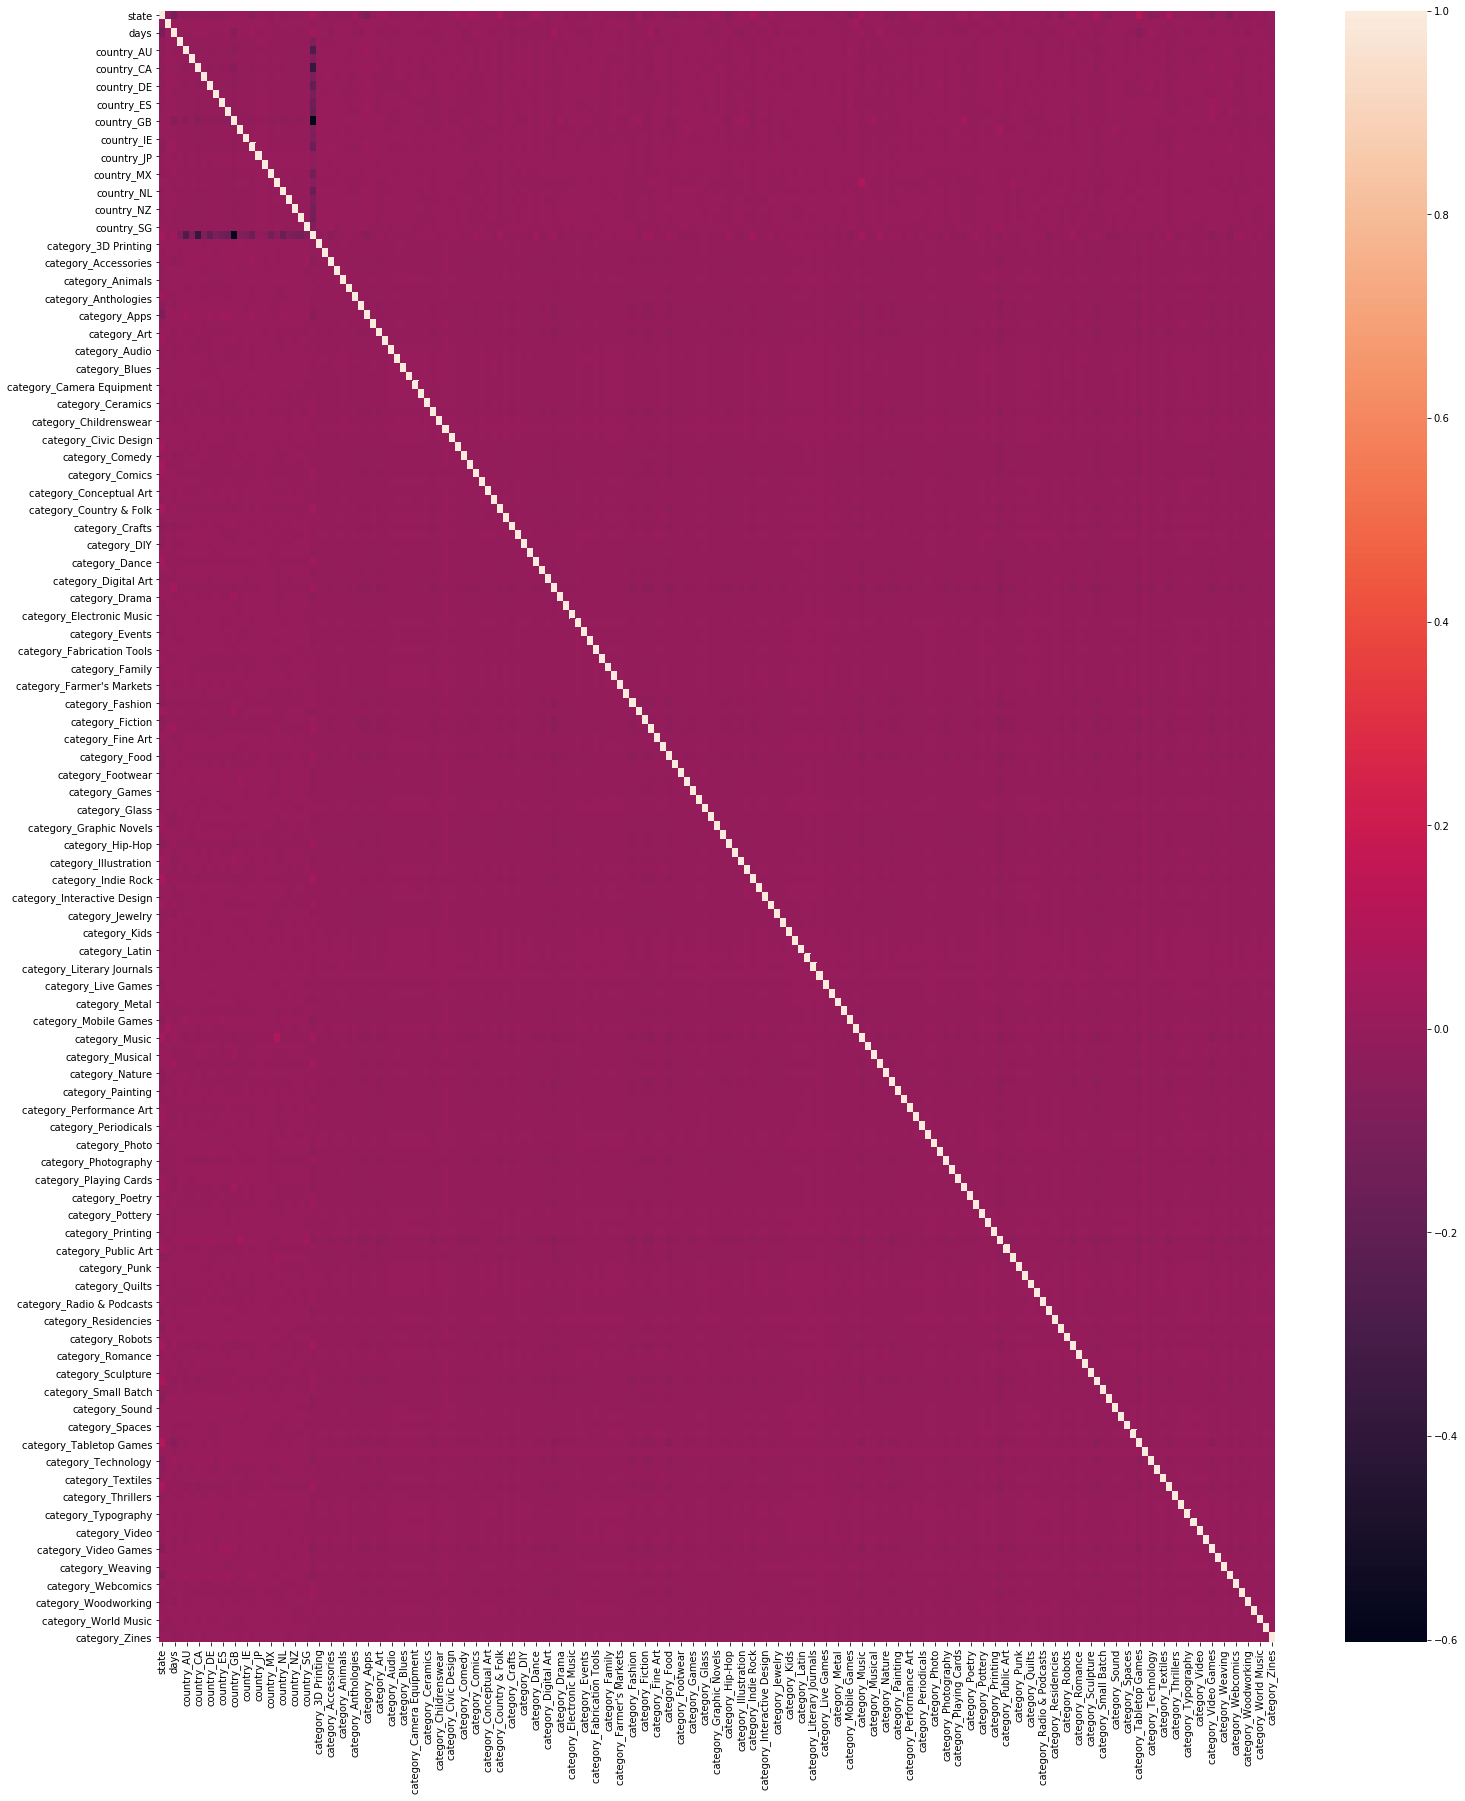

In [17]:
# 相関係数をヒートマップにして可視化
plt.figure(figsize=(25,30))
sns.heatmap(df_cloud.corr())
plt.show()

* 相関関係が強い説明変数は見つからなかった。
* 相関関係から説明変数を削除はしない。

### (2)LASSOを用いて、特徴選択を行う。

In [18]:
estimator = LassoCV(normalize=True, cv=10)
sfm = SelectFromModel(estimator, threshold=1e-5)

Index(['usd_goal_real', 'country_LU', 'country_SE', 'category_Conceptual Art',
       'category_Poetry', 'category_Stationery'],
      dtype='object')


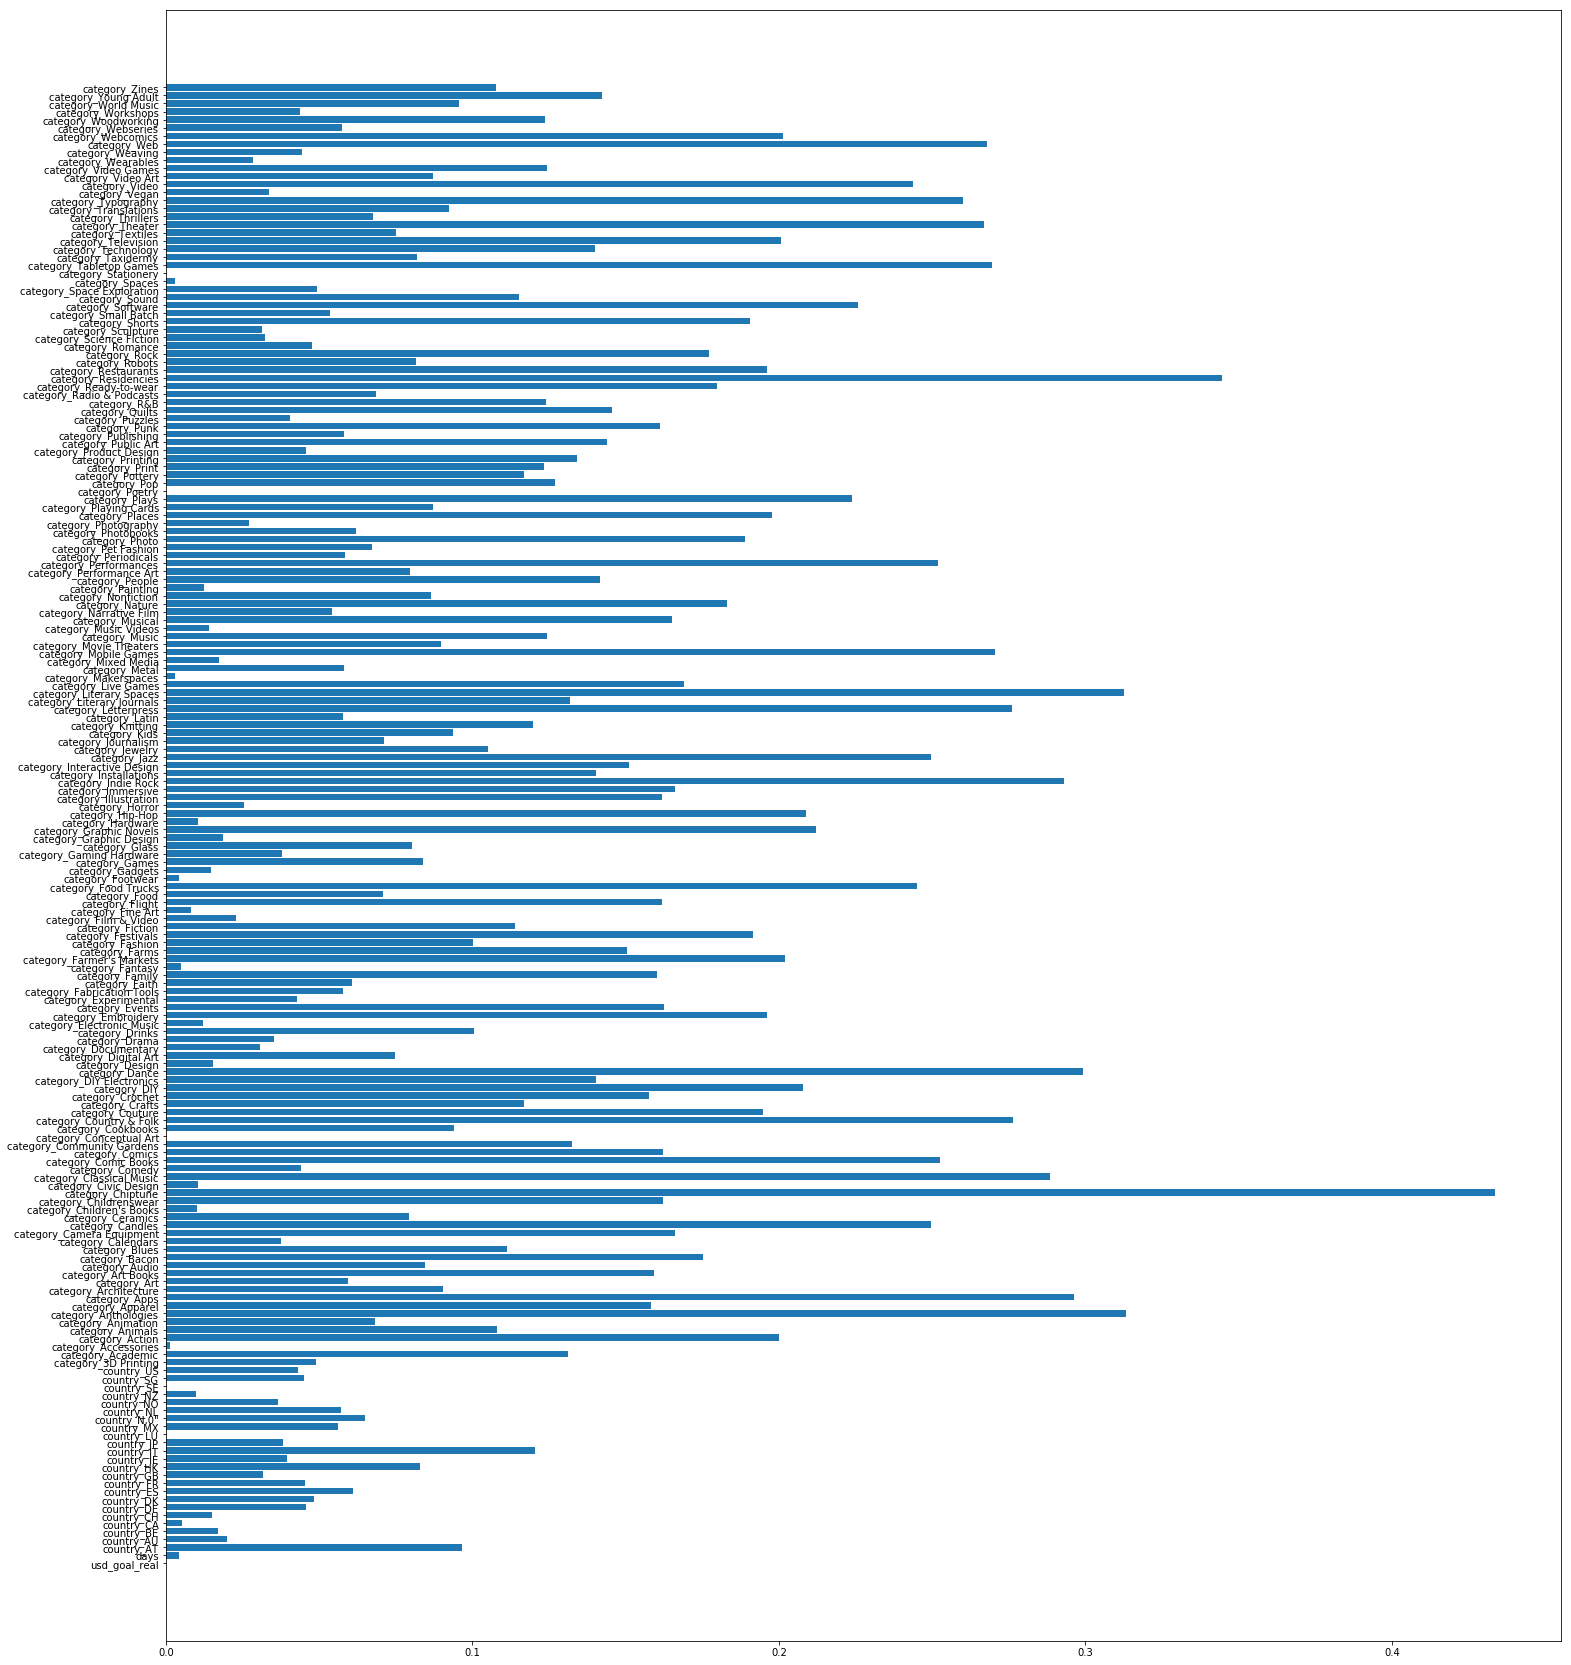

Wall time: 1min 46s


In [19]:
%%time

train_label = df_cloud["state"]
train_data = df_cloud.drop(['state'],axis=1)

X = train_data.values
y = train_label.values

# fitで特徴選択を実行
sfm.fit(X, y)

# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
print(train_data.columns[removed_idx])

# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
#print(abs_coef)

# 係数を棒グラフで表示
plt.figure(figsize=(25,30))
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

### (3)変数削除
* (2)で求めた変数を削除する
* usd_goal_real
* country_LU
* country_SE
* category_Conceptual Art
* category_Poetry
* category_Stationery

In [20]:
df_cloud_lasso = df_cloud.drop(['usd_goal_real','country_LU','country_SE','category_Conceptual Art','category_Poetry','category_Stationery'],axis=1)
df_cloud_lasso.head()

,state,days,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,...,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines
0,False,58,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,59,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,44,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,True,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# 計算用データセット作成
X = df_cloud_lasso.drop(['state'],axis=1).values
y = df_cloud_lasso["state"].values
test_size = 0.2
X_train_fin_lasso, X_test_fin_lasso, y_train_fin_lasso, y_test_fin_lasso = train_test_split(X, y, test_size=test_size,random_state=1234)
print('X_train_fin_lasso：{}'.format(len(X_train_fin_lasso)))
print('y_train_fin_lasso：{}'.format(len(y_train_fin_lasso)))
print('X_test_fin_lasso：{}'.format(len(X_test_fin_lasso)))
print('y_test_fin_lasso：{}'.format(len(y_test_fin_lasso)))

X_train_fin_lasso：265340
y_train_fin_lasso：265340
X_test_fin_lasso：66335
y_test_fin_lasso：66335


In [22]:
# 標準化
stdsc = StandardScaler()
X_train_stand_lasso = stdsc.fit_transform(X_train_fin_lasso)
X_test_stand_lasso = stdsc.transform(X_test_fin_lasso)

C:\Users\ai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### (4)ロジステック回帰にて特徴選択結果を確認

In [23]:
%%time
# 学習用データでロジステック回帰を学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train_stand_lasso, y_train_fin_lasso)

# 学習用データに対する予測を実行
y_est_train = clf.predict(X_train_stand_lasso)

# 学習用データに対する対数尤度を表示
print('訓練誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_train_fin_lasso, y_est_train)))

# 学習用データに対する正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train_fin_lasso, y_est_train)))

# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train_fin_lasso, y_est_train)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
print()

# テスト用データに対する予測を実行
y_est_test = clf.predict(X_test_stand_lasso)

# テスト用データに対する対数尤度を表示
print('汎化誤差')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test_fin_lasso, y_est_test)))

# テスト用データに対する正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test_fin_lasso, y_est_test)))

# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fin_lasso, y_est_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

訓練誤差
対数尤度 = -11.770
正答率 = 65.922%
適合率（Precision） = 67.680%
再現率（Recall） = 81.857%
F1値（F1-score） = 74.096%

汎化誤差
対数尤度 = -11.776
正答率 = 65.905%
適合率（Precision） = 67.906%
再現率（Recall） = 81.670%
F1値（F1-score） = 74.155%
Wall time: 40.6 s


### (5)ロジステック回帰 過学習の確認

|誤差|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|
|訓練誤差|65.922%|67.680%|81.857%|74.096%|
|汎化誤差|65.905%|67.906%|81.670%|74.155%|

* 訓練誤差と汎化誤差はわずかであったため、過学習ではないと判断する。

### (6)ロジステック回帰 特徴選択結果を比較

|手法|標準化|特徴選択|計算時間(学習+予測)|学習データ量|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|ロジステック回帰|あり|なし|43.3 s|100%|66.591%|69.997%|77.386%|73.506%|
|ロジステック回帰|あり|あり|40.6 s|100%|65.905%|67.906%|81.670%|74.155%|

* 特徴選択後、正答率が下がった
* 特徴選択後、計算時間が下がったがもともと計算時間が短いので、ロジステック回帰においては、特徴選択選択は効果的ではなかった。

### (7) SVMにて特徴選択結果を確認
* 学習データを特徴選択前と同じ20%で実施

In [24]:
# 学習データ
test_size = 0.2
X_train_fin_lasso08, X_train_fin_lasso02, y_train_fin_lasso08, y_train_fin_lasso02 = train_test_split(X_train_fin_lasso, y_train_fin_lasso, test_size=test_size,random_state=1234)

In [25]:
# 標準化
stdsc = StandardScaler()
X_train_stand_lasso02 = stdsc.fit_transform(X_train_fin_lasso02)
X_test_stand_lasso = stdsc.transform(X_test_fin_lasso)

C:\Users\ai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ai\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [26]:
%%time
C = 0.5
kernel = "rbf"
gamma = 0.1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train_stand_lasso02, y_train_fin_lasso02)

# 訓練誤差
y_train_est = clf.predict(X_train_stand_lasso02)

# 学習用データに対する正答率を表示
print('訓練誤差:学習データ20%')
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train_fin_lasso02, y_train_est)))

# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train_fin_lasso02, y_train_est)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
print()
# 汎化誤差
y_est_test = clf.predict(X_test_stand_lasso)

# テスト用データに対する正答率を表示
print('汎化誤差')
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test_fin_lasso, y_est_test)))

# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fin_lasso, y_est_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

訓練誤差:学習データ20%
正答率 = 66.656%
適合率（Precision） = 68.091%
再現率（Recall） = 82.651%
F1値（F1-score） = 74.668%

汎化誤差
正答率 = 65.686%
適合率（Precision） = 67.810%
再現率（Recall） = 81.298%
F1値（F1-score） = 73.944%
Wall time: 25min 10s


### (8)ロジステック回帰 過学習の確認

|誤差|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|
|訓練誤差|66.656%|68.091%|82.651%|74.668%|
|汎化誤差|65.686%|67.810%|81.298%|73.944%|

* 訓練誤差と汎化誤差はわずかであったため、過学習ではないと判断する。

### (6)ロジステック回帰 特徴選択結果を比較

|手法|標準化|特徴選択|計算時間(学習+予測)|学習データ量|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|SVM|あり|なし|26min 53s|20%|65.700%|67.822%|81.300%|73.952%|
|SVM|あり|あり|25min 10s|20%|65.686%|67.810%|81.298%|73.944%|

* 特徴選択後、正答率がわずかに下がった。
* 特徴選択後、計算時間が下がったが、わずかであり、思ったほどの効果がなかった。
* LASSOを繰り返せばもう少し効果があるかもしれないが、正答率が下がってしまうので、特徴選択する前のデータセットで別手法を試して精度を上げる。
* 精度が高く、計算時間がかかるモデルとなった場合改めて、特徴選択を実施する。

## 4.ランダムフォレストで精度が上がるか検証する

### (1)パラメータ探索用データセットを準備
* 計算時間短縮のため、学習用データの5%を使用する

In [27]:
print('学習データ全数：{}'.format(len(X_train_fin)))
print('パラメータ探索用データ(5%)：{}'.format(len(X_train_fin005)))

学習データ全数：265340
パラメータ探索用データ(5%)：13267


In [28]:
# 標準化
stdsc = StandardScaler()
X_train_stand005 = stdsc.fit_transform(X_train_fin005)
#X_test_stand = stdsc.transform(X_test_fin)

### (2)パラメータ調整
* (1)で作成したデータを使い、グリッドサーチを行い、パラメータ調整を行う

In [29]:
%%time
parameters = {'n_estimators':[60,70,80,90], 'max_depth':[50,60,70],'min_samples_leaf':[5,10,15],'min_samples_split':[2,3]}
model = RandomForestClassifier(criterion="gini",random_state=1234)

gcv = GridSearchCV(model, parameters, cv=3,verbose=2)
gcv.fit(X_train_stand005, y_train_fin005)
print(gcv.best_params_, gcv.best_score_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=60 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=60, total=   0.6s
[CV] max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=60 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=60, total=   0.6s
[CV] max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=60 
[CV]  max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=60, total=   0.5s
[CV] max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=70 
[CV]  max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=70 
[CV]  max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=70 
[CV]  max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=70, total=   0.6s
[CV] max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=80 
[CV]  max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=80, total=   0.8s
[CV] max_depth=50, min_samples_leaf=5, min_samples_split=2, n_e

[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=60, total=   0.4s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=70 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=70, total=   0.5s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=70 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=70, total=   0.5s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=70 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=70, total=   0.5s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=80 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=80, total=   0.6s
[CV] max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=80 
[CV]  max_depth=50, min_samples_leaf=15, min_samples_split=2, n_estimators=80, total=   0.6s
[CV] max_depth=50, min_samples_leaf=15, min_samples_

[CV]  max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=70, total=   0.5s
[CV] max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=70 
[CV]  max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=70, total=   0.6s
[CV] max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=70 
[CV]  max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=70, total=   0.5s
[CV] max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=80 
[CV]  max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=80, total=   0.6s
[CV] max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=80 
[CV]  max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=80, total=   0.7s
[CV] max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=80 
[CV]  max_depth=60, min_samples_leaf=10, min_samples_split=2, n_estimators=80, total=   0.6s
[CV] max_depth=60, min_samples_leaf=10, min_samples_

[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=70 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=70 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=70, total=   0.7s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=80 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=80, total=   0.8s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=80 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=80, total=   0.8s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=80 
[CV]  max_depth=70, min_samples_leaf=5, min_samples_split=2, n_estimators=80, total=   0.8s
[CV] max_depth=70, min_samples_leaf=5, min_samples_split=2, n_e

[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=70, total=   0.5s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=70 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=70, total=   0.5s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=80 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=80, total=   0.6s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=80 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=80, total=   0.6s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=80 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=80, total=   0.6s
[CV] max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=90 
[CV]  max_depth=70, min_samples_leaf=15, min_samples_split=2, n_estimators=90, total=   0.7s
[CV] max_depth=70, min_samples_leaf=15, min_samples_

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  3.1min finished


{'max_depth': 60, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 80} 0.6757367905329011
Wall time: 3min 5s


### (3)グリッドサーチの結果からパラメータを設定し、実行する
* 0.データセット準備で作成したデータセットで学習を実施

In [30]:
print('学習データ全数：{}'.format(len(X_train_stand_fin)))
print('テストデータ全数：{}'.format(len(X_test_stand_fin)))

学習データ全数：265340
テストデータ全数：66335


In [31]:
%%time
#clf = RandomForestClassifier(n_estimators=70, max_depth=50, criterion="gini",
#                                                 min_samples_leaf=5, min_samples_split=2, random_state=1234)
clf = RandomForestClassifier(n_estimators=80, max_depth=60, criterion="gini",
                                                 min_samples_leaf=5, min_samples_split=2, random_state=1234)


y_est_test = clf.fit(X_train_stand_fin, y_train_fin)
print("score=", clf.score(X_train_stand_fin, y_train_fin))

y_train_est = clf.predict(X_train_stand_fin)

# 学習用データに対する正答率を表示
print('訓練誤差')
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train_fin, y_train_est)))

# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train_fin, y_train_est)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
print()



y_est_test = clf.predict(X_test_stand_fin)

# テスト用データに対する正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test_fin, y_est_test)))

# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fin, y_est_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

score= 0.7111479611065049
訓練誤差
正答率 = 71.115%
適合率（Precision） = 72.113%
再現率（Recall） = 83.954%
F1値（F1-score） = 77.584%

正答率 = 67.993%
適合率（Precision） = 70.085%
再現率（Recall） = 81.227%
F1値（F1-score） = 75.246%
Wall time: 1min 41s


### (4)ランダムフォレスト 過学習の確認

|誤差|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|
|訓練誤差|71.115%|72.113%|83.954%|77.584%|
|汎化誤差|67.993%|70.085%|81.227%|75.246%|

* 訓練誤差と汎化誤差に差が出てきているが、過学習と呼ぶほどではないと判断する。

### (5)他の手法と結果を比較

|手法|標準化|特徴選択|計算時間(学習+予測)|学習データ量|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|ロジステック回帰|あり|なし|43.3 s|100%|66.591%|69.997%|77.386%|73.506%|
|SVM|あり|なし|26min 53s|20%|65.700%|67.822%|81.300%|73.952%|
|ランダムフォレスト|あり|なし|1min 41s|100%|67.993%|70.085%|81.227%|75.246%|

* ロジステック回帰に比べ、正答率が高い。
* SVMに比べ、計算時間が早く、正答率が高い。


## 5.アダブーストで精度が上がるか検証する
* ロジステック回帰、決定木で実施

### (1)アダブースト+ロジステック回帰 

In [32]:
%%time
clf = AdaBoostClassifier(SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3))
clf.fit(X_train_stand_fin, y_train_fin)
print("score=", clf.score(X_train_stand_fin, y_train_fin))

y_train_est = clf.predict(X_train_stand_fin)

# 学習用データに対する正答率を表示
print('訓練誤差')
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train_fin, y_train_est)))

# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train_fin, y_train_est)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
print()

y_est_test = clf.predict(X_test_stand_fin)

# テスト用データに対する正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test_fin, y_est_test)))

# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fin, y_est_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


score= 0.6599683425039572
訓練誤差
正答率 = 65.997%
適合率（Precision） = 67.575%
再現率（Recall） = 82.460%
F1値（F1-score） = 74.279%

正答率 = 65.873%
適合率（Precision） = 67.730%
再現率（Recall） = 82.164%
F1値（F1-score） = 74.252%
Wall time: 1min 24s


### (2)アダブースト+ロジステック回帰 過学習の確認

|誤差|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|
|訓練誤差|65.970%|67.575%|82.374%|74.244%|
|汎化誤差|65.902%|67.771%|82.116%|74.257%|

* 訓練誤差と汎化誤差がわずかなため、過学習なし。

### (3)他の手法と結果を比較

|手法|標準化|特徴選択|計算時間(学習+予測)|学習データ量|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|ロジステック回帰|あり|なし|43.3 s|100%|66.591%|69.997%|77.386%|73.506%|
|アダブースト+ロジステック回帰|あり|なし|1min 24s|100%|65.902%|67.771%|82.116%|74.257%|
|SVM|あり|なし|26min 53s|20%|65.700%|67.822%|81.300%|73.952%|
|ランダムフォレスト|あり|なし|1min 41s|100%|67.993%|70.085%|81.227%|75.246%|

* ロジステック回帰だけの時より、時間がかかり、正答率も下がった。

### (4)アダブースト+決定木
* ランダムフォレストで使用したパラメータで実施

In [33]:
%%time
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=60,
                                                                                 min_samples_leaf=5,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=80, random_state=1234)
clf.fit(X_train_stand_fin, y_train_fin)
print("fit")
print("score=", clf.score(X_train_stand_fin, y_train_fin))

y_train_est = clf.predict(X_train_stand_fin)
print("predict")
# 学習用データに対する正答率を表示
print('訓練誤差')
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train_fin, y_train_est)))

# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train_fin, y_train_est)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
print()

y_est_test = clf.predict(X_test_stand_fin)

# テスト用データに対する正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test_fin, y_est_test)))

# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_fin, y_est_test)
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


fit
score= 0.848993743875782
predict
訓練誤差
正答率 = 84.899%
適合率（Precision） = 85.284%
再現率（Recall） = 90.204%
F1値（F1-score） = 87.675%

正答率 = 63.856%
適合率（Precision） = 68.596%
再現率（Recall） = 73.130%
F1値（F1-score） = 70.790%
Wall time: 34min 19s


### (5)アダブースト+決定木 過学習の確認

|誤差|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|
|訓練誤差|84.899%|85.284%|90.204%|87.675%|
|汎化誤差|63.856%|68.596%|73.130%|70.790%|

* 訓練誤差と汎化誤差の差が大きい。過学習となっている。
* パラメータの調整が必要。→何度か調整したが、過学習が改善されなかった。計算時間、正答率もランダムフォレストに及ばなかったため、採用を見送る。

## 6.まとめ

|手法|標準化|特徴選択|計算時間(学習+予測)|学習データ量|正答率|適合率|再現率|F1値|
|:-|:-|:-|:-|:-|:-|:-|:-|:-|
|ロジステック回帰|あり|なし|43.3 s|100%|66.591%|69.997%|77.386%|73.506%|
|アダブースト+ロジステック回帰|あり|なし|1min 24s|100%|65.902%|67.771%|82.116%|74.257%|
|SVM|あり|なし|26min 53s|20%|65.700%|67.822%|81.300%|73.952%|
|ランダムフォレスト|あり|なし|1min 41s|100%|67.993%|70.085%|81.227%|75.246%|

* ランダムフォレストの正答率67.993%が最も高い結果となった。
* 計算時間と正答率からランダムフォレストの結果を採用する。